# ARIMA and SARIMA

In [1]:
'''
    ----------------------------------------------------------------------------------------------
    April 2022
    Dr. Kamanasish Debnath
    Postdoctoral Researcher
    Wallenberg Center for Quantum Technology (WACQT)
    Chalmers University of Technology
    
    kamanasish.debnath@gmail.com
    Data set used: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
    ----------------------------------------------------------------------------------------------
    
    
    The data set contains atmospheric features such as mean temperature, humidity, wind speed 
    and mean pressure for 113 days in Delhi, India. 
''';

In [49]:
# Import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import datetime 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data exploration

In [23]:
df = pd.read_csv("DailyDelhiClimateTest.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [24]:
# Converting the column date into datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


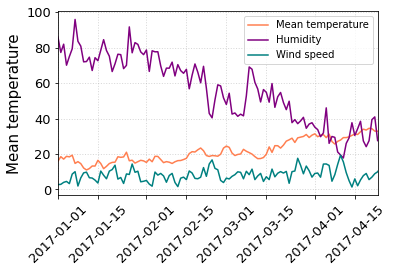

In [25]:
# Plotting the time series data
sns.lineplot(data = df, x=df.index, y='meantemp', color = 'coral', linewidth=1.5, label = 'Mean temperature')
sns.lineplot(data = df, x=df.index, y='humidity', color = 'purple', linewidth=1.5, label = 'Humidity')
sns.lineplot(data = df, x=df.index, y='wind_speed', color = 'teal', linewidth=1.5, label = 'Wind speed')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.xlim([df.index[0], df.index[112]]);
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)

# Mean temperature forecast

## First trend differencing to determine trend differencing order (d)

--------------------------------------------------------------------------------
p-value after 1st differencing is:  2.805321368977763e-22


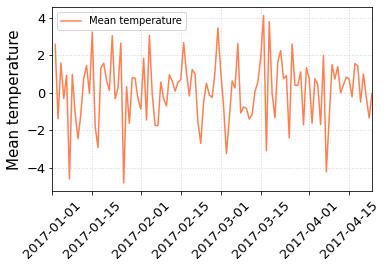

In [44]:
differ_trend = df.meantemp - df.meantemp.shift(1)
sns.lineplot(data = df, x=df.index, y=differ_trend, color = 'coral', linewidth=1.5, label = 'Mean temperature')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.xlim([df.index[0], df.index[112]]);
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)

_,pvalue,_,_,_,_ = adfuller(differ_trend.dropna())
print("-"*80)
print("p-value after 1st differencing is: ", pvalue)

In [76]:
# Checking the seasonality (patterns for minimas)
differ_trend.sort_values(ascending = True)

date
2017-01-26   -4.821429
2017-01-07   -4.609848
2017-04-07   -4.222222
2017-03-03   -3.250000
2017-03-17   -3.100000
                ...   
2017-01-15    3.234783
2017-02-28    3.458333
2017-03-18    3.792308
2017-03-16    4.125000
2017-01-01         NaN
Name: meantemp, Length: 114, dtype: float64

## First seasonal differencing to determine seasonal differencing order (D)

--------------------------------------------------------------------------------
p-value after 1st differencing is:  0.006864712953584405


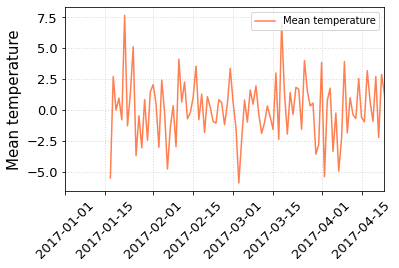

In [83]:
# The plot looks like there is a seasonality of 10-15, hence we set the value to 15

differ_season = differ_trend - differ_trend.shift(15)
sns.lineplot(data = df, x=df.index, y=differ_season, color = 'coral', linewidth=1.5, label = 'Mean temperature')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.xlim([df.index[0], df.index[112]]);
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)

_,pvalue,_,_,_,_ = adfuller(differ_season.dropna())
print("-"*80)
print("p-value after 1st differencing is: ", pvalue)

### Hence we now have 3 out of 7 hyperparameters for SARIMA model- 

d = Trend differencing order = 1 <br>
D = Seasonal differcing order = 1 <br>
lag = 15 <br>

For determining the other parameters necessary for SARIMA, we use the autocorrelation (ACF) and partial autocorrelation (PACF) plots.

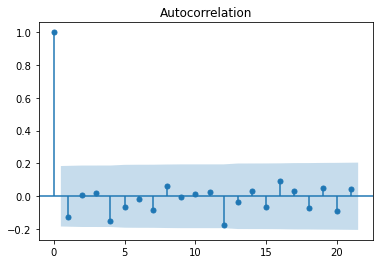

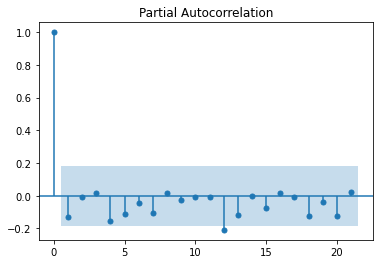

In [87]:
plot_acf(differ_trend.dropna())
plt.show()

plot_pacf(differ_trend.dropna())
plt.show()

FROM PACF plot:- 
p = 0

FROM ACF plot:-
q = 0

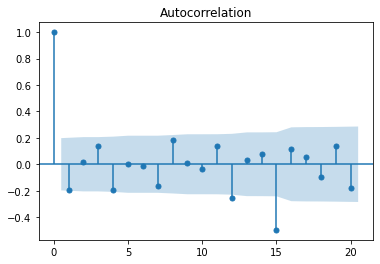

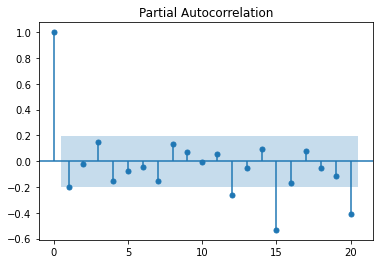

In [88]:
plot_acf(differ_season.dropna())
plt.show()

plot_pacf(differ_season.dropna())
plt.show()

FROM PACF plot:- P = 1

FROM ACF plot:- Q = 1

### Hence the most probable model: 
SARIMA(p,d, q)(P,D,Q)lag = SARIMA(0,1,0)x(1,1,1)15

In [360]:
Train = df.meantemp[:100]
Test = df.meantemp[100:]
mod = SARIMAX(Train,
              order=(0,1,0),
              seasonal_order=(1,1,1,15)).fit()

Ypred = mod.predict(start = 99, end = 113)

C:\Users\debnathk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\debnathk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [386]:
forecast = mod.get_forecast(steps = 14)
forecast_CI = forecast.conf_int()

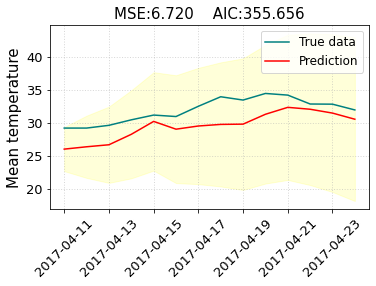

In [393]:
# plt.plot(Train, label = 'True data', color = 'teal')
mse_SARIMA = mean_squared_error(Test, forecast.predicted_mean)
plt.plot(Test, label = 'True data', color = 'teal')
plt.plot(forecast.predicted_mean, color = 'red', label = 'Prediction')
plt.fill_between(forecast_CI.index, 
                 forecast_CI.iloc[:,0],
                 forecast_CI.iloc[:,1],
                color = 'yellow', alpha = 0.15)
plt.legend(fontsize = 15, loc = 'upper left')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)
plt.legend(fontsize = 12)
plt.title("MSE:%1.3f  " % mse_SARIMA + "  AIC:%1.3f" % mod.aic, fontsize = 15)
plt.savefig("SARIMA.pdf")

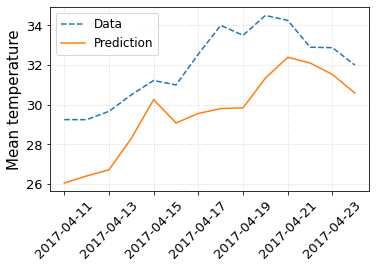

In [301]:
plt.plot(df.meantemp[100:],'--' ,label = 'Data')
plt.plot(Ypred, label = 'Prediction')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)
plt.legend(fontsize = 12)
plt.savefig("SARIMA.pdf")

In [306]:
from pmdarima import auto_arima
stepwise_model = auto_arima(df.meantemp[:100], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=15,
                           start_P=0, end_P = 3, 
                           start_Q=0, end_Q = 3, 
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=399.867, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=373.482, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[15]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=399.044, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[15]             : AIC=360.308, Time=0.18 sec
 ARIMA(1,1,0)(2,1,1)[15]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(1,1,1)[15]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,1,0)[15]             : AIC=363.174, Time=0.12 sec
 ARIMA(2,1,0)(2,1,0)[15]             : AIC=362.104, Time=0.20 sec
 ARIMA(1,1,1)(2,1,0)[15]             : AIC=362.113, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[15]             : AIC=360.914, Time=0.16 sec
 ARIMA(2,1,1)(2,1,0)[15]             : AIC=364.104, Time=0.45 sec
 ARIMA(1,1,0)(2,1,0)[15] intercept   : AIC=361.870, Time=0.29 sec

Best model:  ARIMA(1,1,0)(2,1,0)[15]          
Total fit time: 3.663 seconds


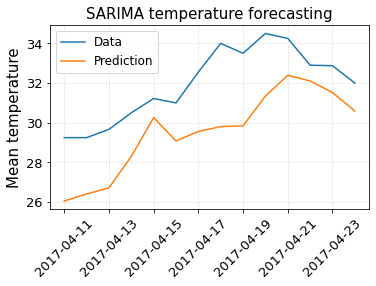

In [324]:
Ypred_pmdarima= stepwise_model.predict(n_periods = 14)
plt.plot(df.index[100:], df.meantemp[100:], label = 'Data')
plt.plot(df.index[100:], Ypred, label = 'Prediction')
# plt.plot(df.index[100:], Ypred_pmdarima,'--' ,label = 'Optimal SARIMA params')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
plt.grid('on', linewidth = 1, linestyle = ':', alpha= 0.5)
plt.xlabel('', fontsize = 15)
plt.ylabel('Mean temperature', fontsize = 15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.24)
plt.legend(fontsize = 12)
plt.title('SARIMA temperature forecasting', fontsize = 15)
plt.savefig("SARIMA.pdf")

In [305]:
mean_squared_error(df.meantemp[100:], Ypred_pmdarima)

4.223687628386124

ValueError: operands could not be broadcast together with shapes (14,) (3,) 

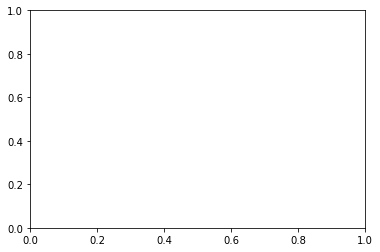

In [322]:
pred_cis = mod.conf_int(alpha = 0.05)
pred_means = Ypred
plt.fill_between(pred_means, pred_cis.iloc[:, 0], pred_cis.iloc[:, 1], alpha=0.05)

In [310]:
Ypred_pmdarima

array([27.19967579, 27.18510561, 28.07549377, 30.3809596 , 32.70114532,
       31.20841824, 30.87813478, 30.25085028, 30.09093067, 30.69167044,
       33.10441302, 32.41336116, 32.24464302, 31.02746391])